# Case studies

1. **Gold standard**: `mine-50-andor` contains the 50 most recent articles from [arxiv.org in both the cs.LG and stat.ML categories](https://arxiv.org/list/cs.LG/recent), between the dates 2022-10-24 and 2022-10-25 and contained 570 search results at the time of the dataset creation. We select articles that belong to cs.LG `or` (cs.LG `and` stat.ML) category.

2. `mine50` contains the 50 most recent articles from [arxiv.org in both the cs.LG and stat.ML categories](https://arxiv.org/list/cs.LG/recent), between the dates 2022-10-24 and 2022-10-25 and contained 570 search results at the time of the dataset creation. The search result is sorted by date in descending order. (*Note:* The date being queried for is the last updated date and not the date of paper submission)

1. `mine50-csLG` contains the results using the same method as `mine50` but without looking for articles in both cs.LG and stat.ML.

## Evaluating ReproScreener on the manually labeled (gold standard) dataset

In [19]:
import pandas as pd
import numpy as np
from IPython.display import display
from pathlib import Path
import sys
import seaborn as sns
from matplotlib import pyplot as plt
sys.path.append(str(Path.cwd().parent / "src"))

path_corpus = Path("../case-studies/arxiv-corpus/mine50-andor/")
manual_path = path_corpus / "manual_eval.csv"

dtypes_repro = {'id': str, 'link_count': float, 'found_links': str}
repro_eval = pd.read_csv(path_corpus / 'output/repro_eval_tex.csv', dtype=dtypes_repro)
repro_eval = repro_eval.drop(columns=['title', 'index', 'affiliation'])

The first 5 articles where ReproScreener found potential code/repository links:

In [20]:
repro_eval_links = repro_eval[repro_eval['link_count'] > 0][['id', 'link_count', 'found_links']]
repro_eval_links.head()

,id,link_count,found_links
4,1909.00931,3.0,['https://github.com/lanwuwei/Twitter-URL-Corp...
8,2009.01947,1.0,['https://gitlab.com/luciacyx/nm-adaptive-code...
9,2010.04261,1.0,['https://github.com/goodfeli/dlbook_notation/']
11,2011.11576,5.0,"['https://github.com/jpbrooks/conjecturing.', ..."
12,2012.09302,1.0,['https://github.com/ain-soph/trojanzoo}.']


Below are the scores from the manually labeled dataset of 50 articles.
- `article_link_avail`: Whether ink to the code/repository was able to be found in the article.
- `pwc_link_avail`: Whether ink to the code/repository was able to be found in the Papers With Code (`pwc`) website.
- `pwc_link_match`: Whether ink to the code/repository found in the Papers With Code (`pwc`) website matches the link found in the article (whether the previous 2 columns match or not).
- `result_replication_code_avail`: Whether code to replicate the specific experiments presented in the article was available. This to measure that the code is not just a generic implementation of the model (part of the tool/package) but is specific to the experiments in the article. If code is not available, this defaults to false.

In [21]:
from repo_downloader import gdrive_get_manual_eval, get_manual_eval_urls
manual = gdrive_get_manual_eval(overwrite=False, manual_path=manual_path)

Manual eval file already exists, use the overwrite flag to download

In [22]:
found_repo_df = get_manual_eval_urls(manual)
manual = manual.merge(found_repo_df[['paper', 'found_repo_url']], on='paper', how='left')
manual['found_repo_url'] = manual['found_repo_url'].apply(lambda x: x[0] if len(x) > 0 else np.nan)
found_repo_df.dropna().head()

,paper,article_link_avail,code_avail_url,result_replication_code_avail,found_repo_url
9,2009.01947,1.0,https://gitlab.com/luciacyx/nm-adaptive-code,1.0,[https://gitlab.com/luciacyx/nm-adaptive-code]
13,2012.09302,1.0,https://github.com/ain-soph/trojanzoo,1.0,[https://github.com/ain-soph/trojanzoo]
16,2104.11893,1.0,https://github.com/jingweio/LGD-GCN,1.0,[https://github.com/jingweio/LGD-GCN]
19,2105.01937,1.0,https://github.com/BrianG13/FLEX,1.0,[https://github.com/BrianG13/FLEX]
21,2106.01528,1.0,https://github.com/dereklhansen/flowselect,1.0,[https://github.com/dereklhansen/flowselect]


In [23]:
manual_df_numerical = manual[['paper', 'article_link_avail', 'pwc_link_avail', 'pwc_link_match', 'result_replication_code_avail']]
# manual_df_numerical = manual_df_numerical.fillna(0) # fill NaN with 0
dtypes_manual = {'paper': str, 'article_link_avail': float, 'pwc_link_avail': float, 'pwc_link_match': float, 'result_replication_code_avail': float}
manual_df_numerical = manual_df_numerical.astype(dtypes_manual) # convert to int
manual_df_numerical[9:15]

,paper,article_link_avail,pwc_link_avail,pwc_link_match,result_replication_code_avail
9,2010.04261,NaN,NaN,NaN,NaN
10,2010.04855,NaN,NaN,NaN,NaN
11,2011.11576,1.0,1.0,0.0,NaN
12,2012.09302,1.0,1.0,1.0,1.0
13,2101.07354,NaN,NaN,NaN,NaN
14,2102.11887,NaN,NaN,NaN,NaN


Tally of manual evaluation of the 50 articles:

In [24]:
manual_df_numerical.sum(axis=0, numeric_only=True)

article_link_avail               23.0
pwc_link_avail                   22.0
pwc_link_match                   19.0
result_replication_code_avail    20.0
dtype: float64

In [25]:
manual_vs_repro = manual_df_numerical.merge(repro_eval_links, left_on='paper', right_on='id', how='left')
# manual_df_numerical.article_link_avail.sum(), manual_df_numerical.result_replication_code_avail.sum()
print(f"Manual evaluation found links in {manual_vs_repro.article_link_avail.sum()} papers, ReproScreener found links in {(manual_vs_repro.link_count>0).sum()} papers")

Manual evaluation found links in 23.0 papers, ReproScreener found links in 21 papers


## Performing file structure and dependency checks on downloaded repositories of the manually labeled articles

In [26]:
from repo_checker import tally_checks_by_paper, get_downloaded_repos, dict_files_to_list, all_checks_by_paper

downloaded_repos = get_downloaded_repos(path_corpus)
manual['repo_downloaded'] = manual['paper'].isin(downloaded_repos)
manual_disp = manual[manual['repo_downloaded'] == True][['paper', 'repo_downloaded', 'found_repo_url']]
# manual_disp_all = manual_disp.copy()
manual_disp["checks"] = manual_disp["paper"].apply(lambda x: tally_checks_by_paper(path_corpus, x, only_found=True, verbose=False))
manual_disp[["tally", "found"]] = pd.DataFrame(manual_disp["checks"].tolist(), index=manual_disp.index)
manual_disp = manual_disp.join(manual_disp["tally"].apply(pd.Series, dtype=float).rename(columns=lambda x: f"tally_{x}"))
manual_disp = manual_disp.join(manual_disp["found"].apply(pd.Series, dtype=object).apply(dict_files_to_list))
manual_disp = manual_disp.drop(columns=["tally", "found", "checks"])

In [27]:
manual_disp

,paper,repo_downloaded,found_repo_url,tally_wrapper_script,tally_parsed_readme,tally_software_dependencies,wrapper_script,parsed_readme,software_dependencies
4,1909.00931,True,https://github.com/yukiar/TransferFT,NaN,NaN,NaN,NaN,NaN,NaN
8,2009.01947,True,https://gitlab.com/luciacyx/nm-adaptive-code,1.0,1.0,NaN,[Makefile],[dependencies],NaN
11,2011.11576,True,https://github.com/jpbrooks/conjecturing,NaN,NaN,NaN,NaN,NaN,NaN
12,2012.09302,True,https://github.com/ain-soph/trojanzoo,NaN,1.0,1.0,NaN,[install],[requirements]
15,2104.11893,True,https://github.com/jingweio/LGD-GCN,1.0,NaN,NaN,[run],NaN,NaN
18,2105.01937,True,https://github.com/BrianG13/FLEX,NaN,1.0,2.0,NaN,[requirements],"[requirements, environment]"
20,2106.01528,True,https://github.com/dereklhansen/flowselect,NaN,NaN,NaN,NaN,NaN,NaN
21,2106.03157,True,https://github.com/kyo-takano/EfficientCube,NaN,NaN,1.0,NaN,NaN,[requirements]
23,2106.06927,True,https://github.com/renanrojasg/adv_robust_auto...,NaN,NaN,2.0,NaN,NaN,"[pip_reqs, conda_reqs]"
24,2106.07704,True,https://github.com/HanGuo97/soft-Q-learning-fo...,2.0,2.0,2.0,"[run_experiments, Dockerfile]","[requirements, setup]","[Dockerfile, requirements]"


In [28]:
df = manual_disp[['paper','wrapper_script', 'parsed_readme', 'software_dependencies']].copy()
# Add a new column to identify the original column
df['original_column'] = df.index

# Melt the dataframe to create a new row for each unique value in the current column
df_melted = pd.melt(df, id_vars=['original_column'])

# Drop any rows with NaN values
df_melted.dropna(inplace=True)

# Create a new column for each unique value in the current column
df_melted = pd.concat([df_melted.drop('value', axis=1),
                       df_melted['value'].str.split(',', expand=True)],
                      axis=1)
if 'value' in df_melted.columns:
    df_melted.drop('value', axis=1, inplace=True)
# Drop the 'value' column
# df_melted.drop('value', axis=1, inplace=True)

# Pivot the dataframe to transpose it
df_pivoted = pd.pivot_table(df_melted, index=['variable', 'original_column'],
                            aggfunc=lambda x: ' '.join(str(v) for v in x))

# Reset the index to create a new column for each original column
df_pivoted.reset_index(level=1, inplace=True)

# Create a new column for the original column
df_pivoted['original_column'] = df_pivoted['original_column'].astype(str).astype(int)

# Pivot the dataframe again to put the original column in its own column
df_final = pd.pivot_table(df_pivoted, index='original_column',
                          columns='variable', values=0)

# Rename the columns
df_final.columns = [f"{col}_val" for col in df_final.columns]

# Reset the index
df_final.reset_index(inplace=True)
df_final

,original_column,paper_val
0,4,1909.00931
1,8,2009.01947
2,11,2011.11576
3,12,2012.09302
4,15,2104.11893
5,18,2105.01937
6,20,2106.01528
7,21,2106.03157
8,23,2106.06927
9,24,2106.07704


In [29]:
manual_disp

,paper,repo_downloaded,found_repo_url,tally_wrapper_script,tally_parsed_readme,tally_software_dependencies,wrapper_script,parsed_readme,software_dependencies
4,1909.00931,True,https://github.com/yukiar/TransferFT,NaN,NaN,NaN,NaN,NaN,NaN
8,2009.01947,True,https://gitlab.com/luciacyx/nm-adaptive-code,1.0,1.0,NaN,[Makefile],[dependencies],NaN
11,2011.11576,True,https://github.com/jpbrooks/conjecturing,NaN,NaN,NaN,NaN,NaN,NaN
12,2012.09302,True,https://github.com/ain-soph/trojanzoo,NaN,1.0,1.0,NaN,[install],[requirements]
15,2104.11893,True,https://github.com/jingweio/LGD-GCN,1.0,NaN,NaN,[run],NaN,NaN
18,2105.01937,True,https://github.com/BrianG13/FLEX,NaN,1.0,2.0,NaN,[requirements],"[requirements, environment]"
20,2106.01528,True,https://github.com/dereklhansen/flowselect,NaN,NaN,NaN,NaN,NaN,NaN
21,2106.03157,True,https://github.com/kyo-takano/EfficientCube,NaN,NaN,1.0,NaN,NaN,[requirements]
23,2106.06927,True,https://github.com/renanrojasg/adv_robust_auto...,NaN,NaN,2.0,NaN,NaN,"[pip_reqs, conda_reqs]"
24,2106.07704,True,https://github.com/HanGuo97/soft-Q-learning-fo...,2.0,2.0,2.0,"[run_experiments, Dockerfile]","[requirements, setup]","[Dockerfile, requirements]"


## Visualizations

### Paper evaluation results

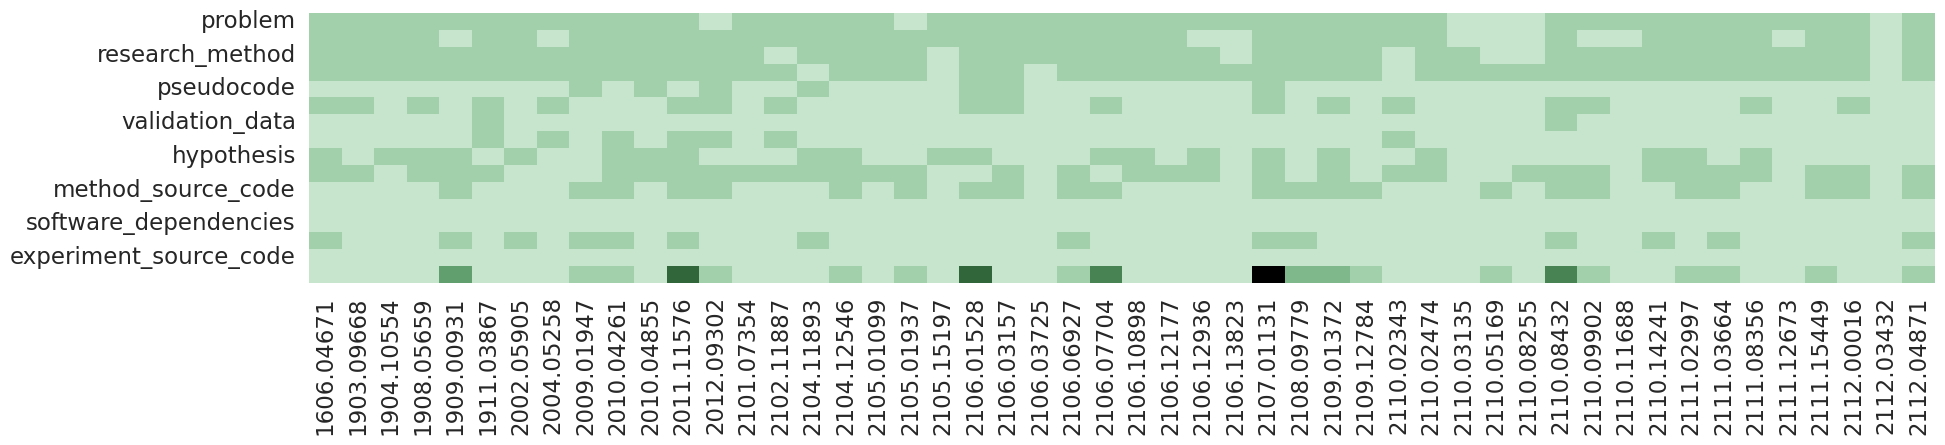

In [87]:
# Merge manual_df_numerical with repro_eval using a left join
all_papers_df = manual_df_numerical.merge(repro_eval, left_on='paper', right_on='id', how='left')

# Fill NaN values in link_count with 0 and found_links with an empty string
all_papers_df['link_count'] = all_papers_df['link_count'].fillna(0)
all_papers_df['found_links'] = all_papers_df['found_links'].fillna("")

# Set the index to 'paper' and remove unnecessary columns
repro_eval_plot = all_papers_df.drop(columns=['id', 'title', 'index', 'affiliation', 'found_links', 'pwc_link_match', 'result_replication_code_avail', 'article_link_avail', 'pwc_link_avail', 'results']).set_index('paper').T

# Plot the heatmap
plt.figure(figsize=(20, 5), tight_layout={"pad": 1.5})
sns.heatmap(repro_eval_plot, cbar=False, cmap=sns.cubehelix_palette(start=2, rot=0, dark=0, light=.85, as_cmap=True))
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
plt.subplots_adjust(top=0.95, left=0.15, right=0.95)
plt.xlabel("")
plt.savefig("../heatmap_manual_eval.png", dpi=900, bbox_inches="tight")
plt.show()
